In [1]:
import os
import torch
from layers import SpatialTransformer
import numpy as np
import nibabel as nib

from skimage.transform import resize
from scipy.ndimage.interpolation import affine_transform

from deformation_simulator import Simulator, SourceGen
from helpers import normalizeImage, random_transform, compute_negative_jacobian
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
folder = "/mnt/blackhole-data2/RadOnc_Brain"
write_dir = "/home/myi16/jsr_Y/md4"

CT_min = -100.0
CT_max = 100.0
CBCT_min = -100.0
CBCT_max = 100.0
T1_min = -100.0
T1_max = 2300.0
config = dict()

config['image_size'] = [128, 160, 128]
config['num_samples'] = 400
config['augment_translation'] = 5
config['augment_rotation'] = 5
config['augment_n_points'] = [1, 5]  # number of points in deformation simulation
config['augment_decay_power_range'] = [1e-2, 6e-2]  # [1e-2,1e-1] [5e-3, 3e-2] [5e-2,9e-2] [9e-3,3e-2] [6e-3,9e-3]# decay power range in deformation simulation
config['augment_deformation_range'] = [2, 5]  # deformation magnitude range in deformation simulation

In [3]:
indices = np.arange(6, 8)
n_moving = []
n_fixed = []
n_cbct = []
n_mask_ventricle = []
n_mask_brain = []
for i in indices:
    n_fixed.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CT-crop-resampled.nii")).get_fdata())
    n_cbct.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CBCT_OArm-crop-resampled.nii")).get_fdata())
    n_moving.append(nib.load(os.path.join(folder, f"NormalAnatomy", f"atlas_brain_{i:02}_T1-crop-resampled.nii")).get_fdata())
    n_mask_ventricle.append(np.squeeze(nib.load(os.path.join(folder, f"MALPEM-MR-Brain-Segmentations",
                                                             f"atlas_brain_{i:02}_T1-crop-resampled_MALPEM.nii.gz")).get_fdata()))
    n_mask_brain.append(nib.load(os.path.join(folder, f"NormalAnatomy_Mask", f"atlas_brain_{i:02}_brain_mask.nii.gz")).get_fdata())

In [4]:
simulator = Simulator(image_size=n_moving[0].shape)
original_shape = n_moving[0].shape
transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
transformer_nearest = SpatialTransformer(original_shape, mode='nearest')

/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
for i in range(config['num_samples']):
    #index = np.random.randint(len(n_moving))
    #index = np.mod(i,5)
    index = 0
    ct = n_fixed[index]
    mr = n_moving[index]
    cbct = n_cbct[index]
    mask_ventricle = n_mask_ventricle[index]
    mask_brain = n_mask_brain[index]

    # Apply rigid transformation
    T = random_transform(list(np.shape(mr)), config['augment_translation'], config['augment_rotation'])
    ct = affine_transform(ct, T, mode='nearest')
    mr = affine_transform(mr, T, mode='nearest')
    cbct = affine_transform(cbct, T, mode='nearest')
    mask_ventricle = affine_transform(mask_ventricle, T, mode='nearest', order=0)
    mask_brain = affine_transform(mask_brain, T, mode='nearest', order=0)

    # Simulate deformations
    n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    source_gen= SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range'], deformation_magnitude_range=config['augment_deformation_range'])
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sim = Simulator(original_shape)
    flow = sim.simulate(sources, mask_brain)

    # Apply deformations
    ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    ct_deform = transformer_linear(ct, flow)
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    mr_deform = transformer_linear(mr, flow)
    cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    cbct_deform = transformer_linear(cbct, flow)
    mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    mask_deform = transformer_nearest(mask, flow)

    # Resize images/masks to target size
    mr = resize(mr.squeeze().numpy(), config['image_size'], order=3)
    mr = normalizeImage(mr, T1_max, T1_min)
    mr_deform = resize(mr_deform.squeeze().numpy(), config['image_size'], order=3)
    mr_deform = normalizeImage(mr_deform, T1_max, T1_min)

    ct = resize(ct.squeeze().numpy(), config['image_size'], order=3)
    ct = normalizeImage(ct, CT_max, CT_min)
    ct_deform = resize(ct_deform.squeeze().numpy(), config['image_size'], order=3)
    ct_deform = normalizeImage(ct_deform, CT_max, CT_min)
    cbct = resize(cbct.squeeze().numpy(), config['image_size'], order=3)
    cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
    cbct_deform = resize(cbct_deform.squeeze().numpy(), config['image_size'], order=3)
    cbct_deform = normalizeImage(cbct_deform, CBCT_max, CBCT_min)

    mask = resize(mask.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    mask_deform = resize(mask_deform.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)

0.003249984283835124

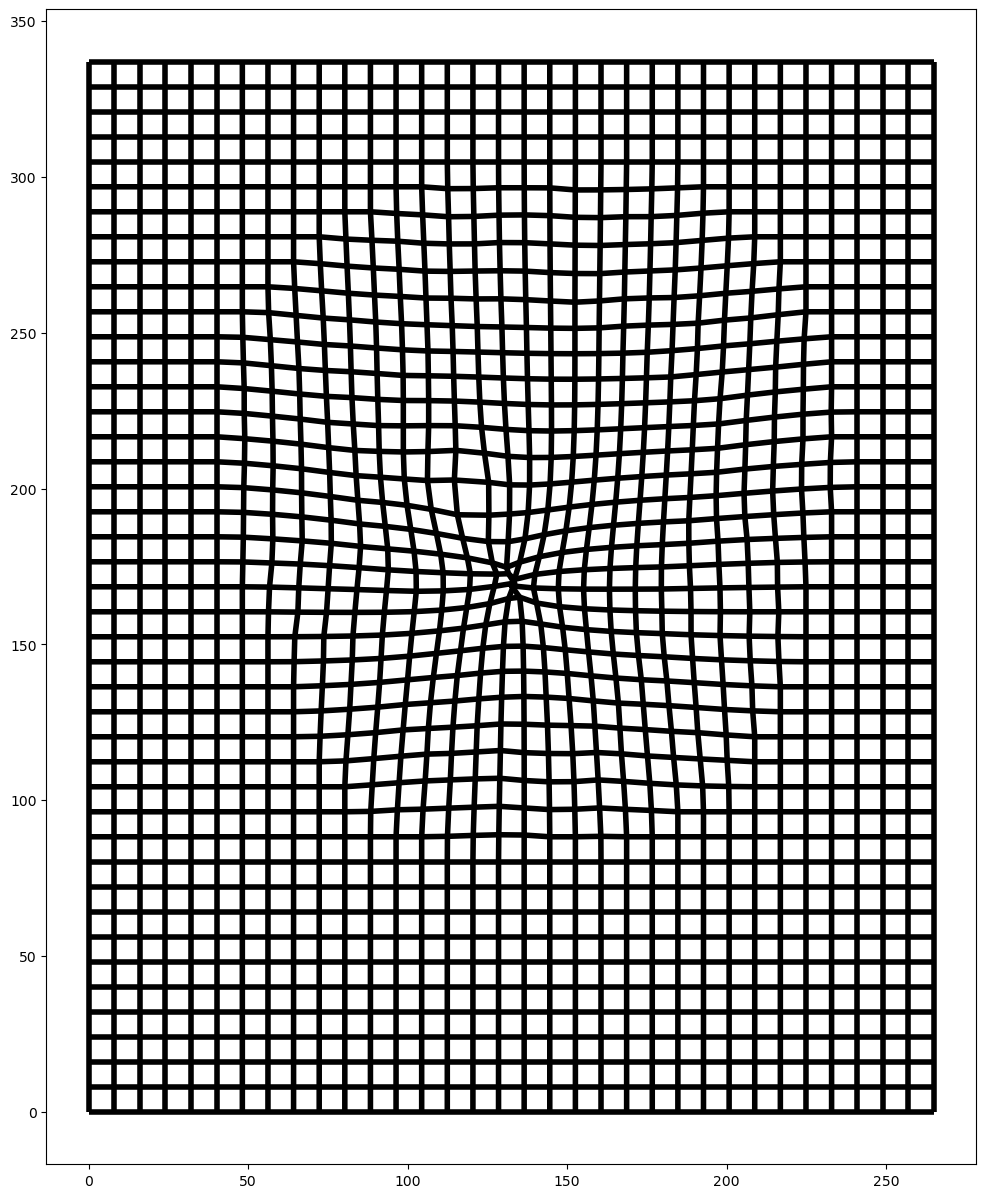

In [7]:
def plot_flow(flow, z, spacing=8, ax=None):
    def plot_grid(x,y, ax=ax, **kwargs):
        ax = ax or plt.gca()
        segs1 = np.stack((x,y), axis=2)
        segs2 = segs1.transpose(1,0,2)
        ax.add_collection(LineCollection(segs1, **kwargs))
        ax.add_collection(LineCollection(segs2, **kwargs))
        ax.autoscale()

    grid_x,grid_y = np.meshgrid(np.linspace(0, flow.shape[1], flow.shape[1]), np.linspace(0, flow.shape[0], flow.shape[0]))
#     plot_grid(grid_x[::spacing, ::spacing],grid_y[::spacing, ::spacing], ax=ax,  color="lightgrey")

    distx = grid_x[::spacing, ::spacing] - flow[::spacing, ::spacing, z, 1]
    disty = grid_y[::spacing, ::spacing] - flow[::spacing, ::spacing, z, 0]
    # distx, disty = f(grid_x,grid_y)
    plot_grid(disty, distx, ax=ax, color="black", linewidths=4)
    
fig, ax = plt.subplots(figsize=(12,15))
plot_flow(flow.squeeze().numpy().transpose((1,2,3,0)), spacing=8, z=100, ax=ax)
compute_negative_jacobian(flow.squeeze().permute(3,2,1,0).numpy())*100

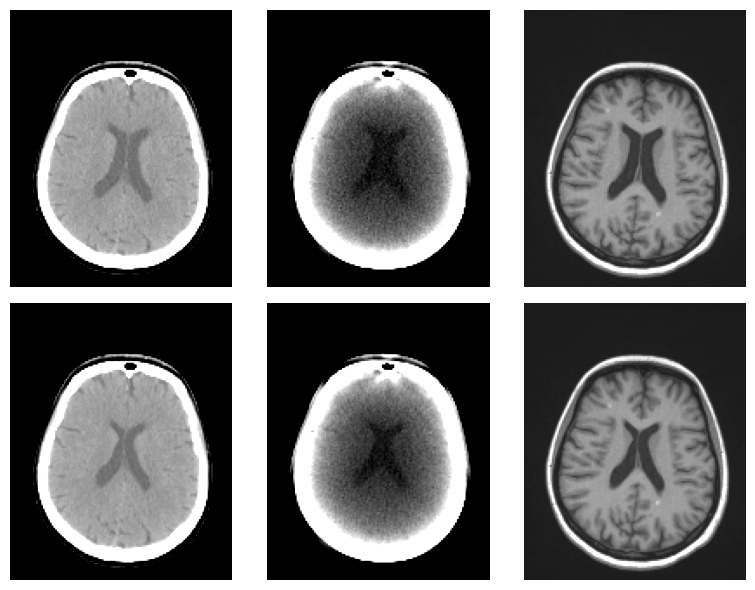

In [8]:
islice = 70

fig, ax = plt.subplots(2,3,figsize=(8,6))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0, 0].imshow(ct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 0].imshow(ct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 1].imshow(cbct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 1].imshow(cbct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 2].imshow(mr[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[1, 2].imshow(mr_deform[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
plt.tight_layout()
plt.show()

In [9]:
flow.shape

torch.Size([1, 3, 271, 340, 183])